In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.initializers import he_normal

In [185]:
Dataset_final = pd.read_csv('Dataset_final.csv',parse_dates=['Date'])
Dataset_final.dataframeName = 'Dataset_final.csv'
display(Dataset_final.head())
print(Dataset_final.shape)
#Dataset_final.set_index('Date',inplace=True)
Dataset_final.sort_values(by=['Date'],inplace=True)

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top24,Top25,Apple compound,Msft compound,DJI returns,S&P 500 returns,Apple returns,Apple Label,Microsoft returns,Microsoft Label
0,2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,...,-0.8519,0.4019,-0.9136,0.0000,0.026151,0.023612,0.035907,1,0.026659,1
1,2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,...,-0.1832,0.0000,0.8948,0.0000,0.004085,0.006919,0.023375,1,-0.008210,0
2,2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,...,0.0000,0.0000,0.1531,0.2023,-0.011943,-0.012124,0.018100,1,0.007854,1
3,2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,...,-0.4215,-0.3400,0.0000,-0.8074,-0.009451,-0.002920,0.014437,1,-0.007496,0
4,2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,...,-0.6908,0.7096,0.7717,0.0000,0.007168,0.005507,0.000112,1,0.000000,1


(1989, 34)


In [200]:
X,y = Dataset_final.drop(columns=['Apple returns','Apple Label','Microsoft Label','Date','Top6','Top7','Top8','Top9'
                                ,'Top10','Top11','Top12','Top13','Top14','Top15',
                                'Top16','Top17','Top18','Top19','Top20','Top21','Top22',
                                'Top23','Top24','Top25']).copy(), Dataset_final['Apple returns'].copy()

# train test split
train = ('2008-08-08' <= Dataset_final['Date']) & (Dataset_final['Date'] < '2011-08-08')
vali = ('2011-08-08' <= Dataset_final['Date']) & (Dataset_final['Date'] < '2012-08-08')
test = ('2012-08-08' <= Dataset_final['Date']) & (Dataset_final['Date'] < '2013-08-08')

# normalisation Z = (x-μ)/σ

X -= X.loc[train+vali].mean() #-μ
X /= X.loc[train+vali].std() #/σ

X

C:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Top1,Top2,Top3,Top4,Top5,Apple compound,Msft compound,DJI returns,S&P 500 returns,Microsoft returns
0,-0.923488,0.517740,-0.346083,-1.093074,-1.548843,-2.163470,-0.311552,1.632536,1.333236,1.273860
1,2.201985,-0.183933,1.456210,0.051992,0.519228,0.670808,-0.311552,0.247561,0.386627,-0.398506
2,0.457464,0.517740,-1.297818,-0.877424,0.519228,-0.491647,0.182306,-0.758392,-0.693213,0.371970
3,-1.186336,-1.262682,-0.965959,0.205069,-0.621115,-0.731599,-2.282590,-0.601958,-0.171290,-0.364265
4,0.847319,0.517740,1.996718,-1.450627,-0.848469,0.477875,-0.311552,0.441103,0.306550,-0.004741
...,...,...,...,...,...,...,...,...,...,...
1984,-0.099379,1.120181,-0.965959,0.261608,1.941641,-0.541957,1.729305,-0.955554,-1.041299,-1.371550
1985,2.237327,-0.493974,1.576498,1.202197,-1.204239,-1.059318,-0.311552,0.970285,0.993124,0.985211
1986,0.400476,-0.983513,2.215934,-1.169277,-0.464334,-1.159781,-0.978493,1.010172,0.952019,1.050676
1987,0.400476,-0.395404,1.369648,-1.505378,-0.848469,-1.690934,-0.311552,0.820340,0.758345,0.589427


In [201]:
def train_nn(X,y,x_val,y_val,lamda = 0.0001,p = 0.2,epochs = 20,learning = 2e-4, b_1 = 0.8, b_2 = 0.999):

    model = Sequential()
    
    model.add(Dense(18, activation='relu',
                    kernel_regularizer=l2(l=lamda), 
                    kernel_initializer=he_normal(),
                    input_dim=X.shape[1])) # number of columns
    model.add(Dropout(p))
   
    model.add(Dense(18, activation='relu',
                    kernel_regularizer=l2(l=lamda),
                    kernel_initializer=he_normal()))
    model.add(Dropout(p))
    
    model.add(Dense(9, activation='relu',
                    kernel_regularizer=l2(l=lamda),
                    kernel_initializer=he_normal()))
    model.add(Dropout(p))

    model.add(Dense(6, activation='relu',
                    kernel_regularizer=l2(l=lamda),
                    kernel_initializer=he_normal()))
    model.add(Dropout(p))    
    
    model.add(Dense(1, activation='linear',
                    kernel_initializer=he_normal()))

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning, beta_1=b_1, beta_2=b_2),
                  metrics=['mse'])
    
    tf.keras.backend.set_learning_phase(True)
    history = model.fit(X,y,validation_data=(x_val, y_val),
                     epochs=epochs, batch_size=300,
                     verbose=1)
    tf.keras.backend.set_learning_phase(False)

    return model,history

In [202]:
def lstm_model(train_x, train_y, valid_x, valid_y):
    
    # define early stopping
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_r2', patience=50, mode="max", 
                                                restore_best_weights=True)
    # design network
    model = tf.keras.Sequential()
    model.add(LSTM(30, activation="relu", input_shape=(None, train_x.shape[1]),
                    return_sequences=True, dropout=0.4))
    model.add(LSTM(15, activation="relu", return_sequences=False,))                     
    model.add(Dense(1))
    
    # model compile & fit
    model.compile(loss='mse',  optimizer=RMSprop(lr=0.0005))
    history = model.fit(train_x, train_y, epochs=1000, batch_size=256, validation_data=(valid_x, valid_y), 
                        verbose=2, callbacks=[earlystopper], shuffle=False)
    
    return model,history

Train on 755 samples, validate on 253 samples
Epoch 1/20
755/755 [==============================] - 0s 219us/sample - loss: 3.9838 - mse: 3.9740 - val_loss: 3.9756 - val_mse: 3.9658
Epoch 2/20
755/755 [==============================] - 0s 16us/sample - loss: 3.6696 - mse: 3.6598 - val_loss: 3.6751 - val_mse: 3.6653
Epoch 3/20
755/755 [==============================] - 0s 20us/sample - loss: 3.3841 - mse: 3.3742 - val_loss: 3.4028 - val_mse: 3.3929
Epoch 4/20
755/755 [==============================] - 0s 24us/sample - loss: 3.1130 - mse: 3.1032 - val_loss: 3.1580 - val_mse: 3.1482
Epoch 5/20
755/755 [==============================] - 0s 24us/sample - loss: 2.8723 - mse: 2.8624 - val_loss: 2.9361 - val_mse: 2.9263
Epoch 6/20
755/755 [==============================] - 0s 20us/sample - loss: 2.6665 - mse: 2.6567 - val_loss: 2.7345 - val_mse: 2.7247
Epoch 7/20
755/755 [==============================] - 0s 16us/sample - loss: 2.4675 - mse: 2.4577 - val_loss: 2.5581 - val_mse: 2.5483
Epoch 8/

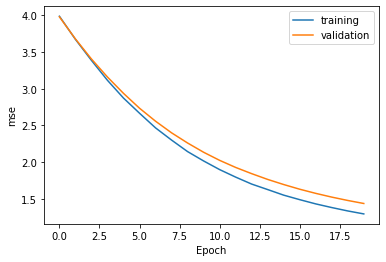

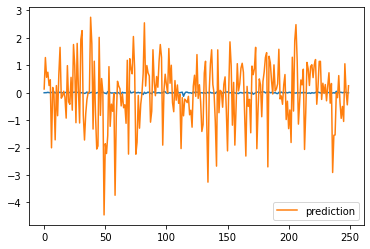

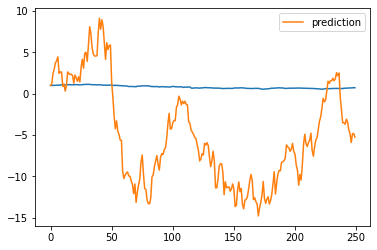

In [222]:
lamda = 0.001   
p = 0.1     
epochs = 10    
learning =0.95
b_1 = 0.8           
b_2 = 0.999  

# train neural net
model,history =  train_nn(X[train],y[train],X[vali],y[vali])
# visualise learning
plt.figure()
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.ylabel('mse')
plt.xlabel('Epoch')
# performance evaluation
metrics = model.evaluate(X[train],y[train])
mse_base = metrics[1]
print('Training MSE in baseline model: %.3f' % mse_base)

metrics = model.evaluate(X[test],y[test])
mse_OOS = metrics[1]
print('Out of sample testing MSE: %.3f' % mse_OOS)

y_pred = model.predict(X[test])

pred_cum = []
real_cum = []

for i in range(len(y_pred)):
    pred_cum.append(sum(y_pred[:i])+1)
    real_cum.append(sum(y[test][:i])+1)



plt.figure()
plt.plot(y[test].values)
plt.plot(y_pred,label = 'prediction')
plt.legend()
plt.show()

plt.figure()
plt.plot(real_cum)
plt.plot(pred_cum,label = 'prediction')
plt.legend()
plt.show()




In [181]:
X[train].shape

(503, 10)